### Notebook for testing model functions with input data and examining output

To do:
* hydrology model uses a sustainable flow parameter, as in INCA. This is a fudge and needs replacing
* Add saturation excess to quick flow
* See notes in Word doc on the sediment equations, together with a to do list specifically relating to suspended sediment
* As sediment equations don't use stream velocity, the only thing it's used in at the moment is to calculate the reach time constant. Excessive, as it's two parameters? Can't re-calculate using v=Q/A, as it becomes circular when you try to work out T and V. Other options to reduce the number of parameters?

In [32]:
# Import modules
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sn, emcee, corner, mpld3
from scipy import optimize
import numpy as np, pandas as pd
from scipy.integrate import odeint
from scipy.stats import norm
sn.set_context('notebook')

In [33]:
# Unit conversions
def UC_Q(Q_mmd, A_catch):
    """Convert discharge from units of mm/day to m3/day"""
    Q_m3d = Q_mmd*1000*A_catch
    return Q_m3d

def UC_Qinv(Q_m3s, A_catch):
    """Convert discharge from units of m3/s to mm/day"""
    Q_mmd = Q_m3s * 86400/(1000*A_catch)
    return Q_mmd

def UC_C(C_kgmm, A_catch):
    """Convert concentration from units of kg/mm to mg/l
    Divide answer by 10**6 to convert from mg/mm to mg/l"""
    C_mgl = C_kgmm/A_catch
    return C_mgl

def UC_Cinv(C_mgl, A_catch):
    """Convert concentration from units of mg/l to kg/mm"""
    C_kgmm = C_mgl*A_catch
    return C_kgmm
    
def UC_V(V_mm, A_catch, outUnits):
    """Convert volume from mm to m^3 or to litres. outUnits 'm3' or 'l'"""
    factorDict = {'m3':10**3, 'l':10**6}
    V = V_mm * factorDict[outUnits] * A_catch
    return V

In [34]:
V_mm = 1.
V_m3 = UC_V(V_mm, 56, 'm3')
V_l = UC_V(V_mm, 56, 'l')

print V_m3, V_l

56000.0 56000000.0


In [35]:
# SNOW ACCUMULATION AND MELT

# Source for priors for DDF: http://directives.sc.egov.usda.gov/OpenNonWebContent.aspx?content=17753.wba
# To Do:
# (1) Add options for how temperature is assumed to vary through the day. At the moment, assume average
# temperature throughout the day. In future, could look at triangular or sinuosoidal variations throughout
# the day, to get a more accurate portrayal of the degree-days above the threshold.
# Also assumes no melting below 0 deg C.

# (2) Consider setting ET to 0 when D_snow > 0.

def hydrol_inputs(D_snow_0, f_DDSM, met_df):
    """Function to calculate snow accumulation and melt.
    Calculates total hydrological input to soil box as precipitation as precipitation as rain + snowmelt
    
    D_snow_0: Initial snow depth (mm)
    f_DDSM: Degree-day factor for snow melt (mm/degree-day deg C)
    met_df: Dataframe of met data with cols T_air, PET, Pptn
    
    Returns met_df with additional columns [P_snow, P_rain, P_melt, D_snow_start
    D_snow_end, P]
    
    Of these, P is the hydrological input to the soil store
    """

    # Calculate precipitation falling as snow and add to met_df
    met_df.loc[:,'P_snow'] = met_df['Pptn'].ix[met_df['T_air']<0]
    met_df['P_snow'].fillna(0, inplace=True)

    # Calculate precipitation falling as rain and add to met_df
    met_df['P_rain'] = met_df['Pptn'] - met_df['P_snow']

    # Calculate daily snow melt, if unlimited snow pack depth to melt (mm/day)
    met_df['P_melt'] = f_DDSM*(met_df['T_air']-0)
    met_df['P_melt'][met_df['P_melt']<0]=0  # Set negative values to 0

    # Calculate snow pack depth
    met_df['D_snow_start'] = np.nan
    met_df['D_snow_end'] = np.nan

    # First time-step manually, to take initial condition into account
    met_df.ix[0,'D_snow_start'] = D_snow_0 #Assign start snow depth to first row
    met_df.ix[0,'P_melt'] = np.minimum(met_df.ix[0,'P_melt'],met_df.ix[0,'D_snow_start'])
    met_df.ix[0,'D_snow_end'] = met_df.ix[0,'D_snow_start']+met_df.ix[0,'P_snow']-met_df.ix[0,'P_melt']

    # Calculte for subsequent days
    for idx in range (1,len(met_df)):
        met_df.ix[idx,'D_snow_start'] = met_df.ix[idx-1,'D_snow_end']
        met_df.ix[idx,'P_melt'] = np.minimum(met_df.ix[idx,'P_melt'],met_df.ix[idx,'D_snow_start'])
        met_df.ix[idx,'D_snow_end'] = met_df.ix[idx,'D_snow_start']+met_df.ix[idx,'P_snow']-met_df.ix[idx,'P_melt']

    # Hydrological input to soil box
    met_df.loc[:,'P'] = met_df['P_rain'] + met_df['P_melt']
    
    return met_df

In [36]:
def P_model_1(met_df, ics, p, period, step_len=1):
    """ Firs hydrology & sediment model

            met_df         Dataframe containing columns 'Rainfall_mm' and 'PET_mm', with datetime index
            ics            Vector of initial conditions [Vs0, Qg0, Qr0]
            p              Series of parameter values (index = param name)
                           Includes the extra param q_gw_min
            period         Vector of [start, end] dates [yyyy-mm-dd, yyyy-mm-dd]
            step_len       Length of each step in the input dataset (days)

        Returns a dataframe with column headings
        ['Vs', 'Qs', 'Vg', 'Qg', 'Vr', 'Qr', 'Dr','Qq', 'Mland']
        (soil water volume and flow, groundwater volume and flow, reach volume
        and flow, mean average daily flow in reach, quick flow)
        
        Future needs: Add in saturation excess to help simulate winter peaks
    """
    # ------------------------------------------------------------------------
    # Define the ODE system
    def ode_f(y, t, ode_params):
        """ Define ODE system.
                y is list or variables for which we want to determine their value at the end of
                    the time step
                    [Vs, Qs, Vg, Qg, Vr, Qr, Dr, Msus]
                t is an array of time points of interest
                params is a tuple of input values & model params:
                    (P, E, Qq_i, Mland_i, f_IExcess, alpha, beta, T_s, T_g, fc, L_reach,
                    a_Q, b_Q, E_Q, k_EQ)
        """
        # Unpack incremental values for initial conditions for this time step 
        # Hydrology
        Vs_i = y[0] # Soil water volume (mm)
        Qs_i = y[1] # Soil water flow (mm/day)
        Vg_i = y[2] # Groundwater volume (mm)
        Qg_i = y[3] # Groundwater discharge (mm/day)
        Vr_i = y[4] # Reach volume (mm)
        Qr_i = y[5] # Reach discharge (mm/day)
        # (Dr_i would be y[6], but it's 0 at the start of every time step)
        # Sediment
        Msus_i = y[7] # Mass of suspended sediment in the stream reach (kg)
        # Phosphorus
        Plab_i = y[8] # Mass of labile P in the soil (kg)
        TDPs_i = y[9] # Mass of total dissolved P in soil water (kg)
        
        # Unpack params
        (P, E, Qq_i, Mland_i, f_IExcess, alpha, beta, T_s,
        T_g, fc, L_reach, S_reach, A_catch, a_Q, b_Q, E_Q, k_EQ,
        P_netInput, EPC0, Kf, Msoil, E_PP) = ode_params
    
        # Soil equations (units mm or mm/day)
        dQs_dV = (((Vs_i - fc)*np.exp(fc - Vs_i))/(T_s*((np.exp(fc-Vs_i) + 1)**2)))
        +(1/(T_s*(np.exp(fc-Vs_i) + 1)))
        dVs_dt = P*(1-f_IExcess) - alpha*E*(1 - np.exp(-0.02*Vs_i)) - Qs_i
        dQs_dt = dQs_dV*dVs_dt
        
        # Groundwater equations (units mm or mm/day)
        dQg_dt = (beta*Qs_i - Qg_i)/T_g
        dVg_dt = beta*Qs_i - Qg_i
        
        # Instream equations (units m3 or m3/s)
        # Units: factors in dQr_dt convert units of instream velocity (aQ^b) from m/s to mm/s, the
        # time constant from s to days & L_reach from m to mm
        dQr_dt = ((Qq_i + (1-beta)*Qs_i + Qg_i) - Qr_i)* a_Q*(Qr_i**b_Q)*(8.64*10**7)/((1-b_Q)*(L_reach*1000))
        dVr_dt = (Qq_i + (1-beta)*Qs_i + Qg_i) - Qr_i
        dDr_dt = Qr_i
        
        # Instream suspended sediment (kg; change in kg/day)
        dMsus_dt = Mland_i + E_Q*S_reach*(Qr_i**k_EQ) - (Msus_i/Vr_i)*Qr_i #Units: (kg/day) - (kg/mm)*(mm/day)
        
        # Soil phosphorus
        
        # Change in labil P content (kg/day) = net sorption
        # Note sorption equation: Kf = Plab_conc/EPC0 = Plab/(EPC0 * Msoil)...
#         dPlab_dt = (10**-6*(Plab_i/EPC0)*((TDPs_i/Vs_i)-EPC0)) #- Mland_i*E_PP*Plab_i
        dPlab_dt = (Kf*Msoil*((TDPs_i/Vs_i)-EPC0))
        
        # Change in dissolved P mass in soil water (kg/day)
        dTDPs_dt = ((P_netInput*100*A_catch/365) 
                    -(Kf*Msoil*((TDPs_i/Vs_i)-EPC0)) # Net sorption (kg/day)
                   - (Qs_i*TDPs_i/Vs_i) # Outflow via soil water flow (kg/day)
                   - (Qq_i*TDPs_i/Vs_i)) # Outflow via quick flow (kg/day)
        
        # Add results of equations to an array
        res = np.array([dVs_dt, dQs_dt, dVg_dt, dQg_dt, dVr_dt, dQr_dt, dDr_dt, dMsus_dt,
                       dPlab_dt, dTDPs_dt])
        
        return res
    # -------------------------------------------------------------------------

    # Unpack user-supplied initial conditions
    
    # 1) Hydrology
    # (initial soil water volume, groundwater flow, instream flow)
    Vs0, Qg0, Qr0_m3s= ics
    # Convert units of Qr0 to mm/day
    Qr0 = UC_Qinv(Qr0_m3s, p['A_catch'])
    
    # 2) Sediment
    # Assume initial suspended sediment mass is 0 kg, and have short burn-in period
    Msus0 = 0.0
    
    # 3) Terrestrial P
    # Soil mass (kg; remove per m2 from units)
    p['Msoil'] = p['Msoil_m2'] * 10**6 * p['A_catch'] # Units: kgSoil/m2 * m2/km2 * km2
    # Convert units of EPC0 from mg/l to kg/mm
    p['EPC0'] = UC_Cinv(p['EPC0_mgl'], p['A_catch'])
    # Calculate initial soil labile P mass (kg) from soil P:soil ratio (mg P/kg soil)
    # NB just for arable at the mo!!!!!!!!!!!!!!!!!!!
    # (Units: kgP/mgP * mgP/kgSoil * kgSoil
    Plab0 = 10**-6*(p['SoilPconc_A']-p['SoilPconc_SN']) * p['Msoil']
    # for SN: Plab0 = 0
    # Calculate initial soil water TDP mass (kg) from EPC0 (kg/mm) and Vs0 (mm)
    TDPs0 = p['EPC0'] * Vs0
    # Calculate Kf (soil adsorption coefficient; mm/kg soil) (kgP/mgP * mgP/kgSoil * mm/kgP)
    p['Kf'] = 10**-6 * (p['SoilPconc_A']-p['SoilPconc_SN'])/p['EPC0']  # Assume SN has EPC0=0, PlabConc =0
    
    
    # Time points to evaluate ODEs at. We're only interested in the start and
    # the end of each step
    ti = [0, step_len]

    # Lists to store output
    output_ODEs = []  # From ode_f function
    output_nonODE = []  # Will include: Qq, Mland

    # Loop over met data
    for idx in range(len(met_df)):

        # Get P and E for this day
        P = met_df.ix[idx, 'P']
        E = met_df.ix[idx, 'PET']

        # Calculate infiltration excess (mm/(day * catchment area))
        Qq_i = p['f_IExcess']*P
        
        # Calculate terrestrial erosion and delivery to the stream, Mland (kg/day)
        Mland_i = p['E_land']*(Qq_i**p['k_Eland']) #Units: (kg/mm)*(mm/day)
        
        # Append to results
        output_nonODE_i = [Qq_i, Mland_i]
        output_nonODE.append(output_nonODE_i)

        # Calculate additional initial conditions from user-input initial conditions
        # Soil and groundwater
        Qs0 = (Vs0 - p['fc'])/(p['T_s']*(1 + np.exp(p['fc'] - Vs0)))
        Vg0 = Qg0 *p['T_g']
        # Instream hydrol
        Tr0 = (1000*p['L_reach'])/(p['a_Q']*(Qr0**p['b_Q'])*(8.64*10**7)) #Reach time constant (days), where T=L/aQ^b
        Vr0 = Qr0*Tr0 # i.e. V=QT (mm)

        # Vector of initial conditions for start of time step
        # Assume 0 for Dr0 (daily mean instream Q)
        y0 = [Vs0, Qs0, Vg0, Qg0, Vr0, Qr0, 0.0, Msus0, Plab0, TDPs0]

        # Model parameters plus rainfall and ET, for input to solver
        ode_params = np.array([P, E, Qq_i, Mland_i, p['f_IExcess'],p['alpha'], p['beta'],
                              p['T_s'], p['T_g'], p['fc'], p['L_reach'], p['S_reach'], p['A_catch'],
                              p['a_Q'], p['b_Q'],
                              p['E_Q'], p['k_EQ'],
                              p['P_netInput'], p['EPC0'], p['Kf'], p['Msoil'], p['E_PP']])

        # Solve
        y = odeint(ode_f, y0, ti, args=(ode_params,))

        # Extract values for end of step
        res = y[1]

        # Numerical errors may result in very tiny values <0
        # set these back to 0
        res[res<0] = 0
        output_ODEs.append(res)

        # Update initial conditions for next step (for Vs0, Qg0, Qr0, Msus0, Plab0, TDPs0)
        Vs0 = res[0]
        # FUDGE to re-set groundwater to user-supplied min flow at start of each time step!!!
        if param_dict['Qg_min'] > res[3]:
            Qg0 = p['Qg_min']
        else:
            Qg0 = res[3]
        Qr0 = res[5]
        Msus0 = res[7]
        Plab0 = res[8]
        TDPs0 = res[9]

    # Build a dataframe of ODE results
    df1 = pd.DataFrame(data=np.vstack(output_ODEs),
                      columns=['Vs', 'Qs', 'Vg', 'Qg', 'Vr', 'Qr', 'Dr', 'Msus', 'P_labile',
                              'TDP_soil_kg'],
                      index=met_df.index)
    
    # Dataframe of non ODE results
    df2 = pd.DataFrame(data=np.vstack(output_nonODE), columns=['Qq', 'Mland'],
                      index=met_df.index)

    # Concatenate results dataframes
    df = pd.concat([df1,df2], axis=1)

    return df

In [37]:
# USER INPUT

# Met and observed data file paths
metdata_fpath = r'M:\Working\NewModel\ModelInputs\Tar_AvMetData_1981-2010.csv'
Qobsdata_fpath = r'M:\Working\NewModel\ModelInputs\obs_csvs\Coull_9amDailyMeanQ_oldRating.csv'
chemObsData_fpath = r'M:\Working\NewModel\ModelInputs\obs_csvs\WholePeriod\TarChem_R4_SS-P.csv'

# Simulation period
st_dt = '2004-01-01'  # Start date
end_dt = '2005-12-31' # End date

# Include snow melt and accumulation module?
inc_snowmelt = 1

# Snow melt parameters
D_snow_0 = 0.  # Initial snow depth (mm)
f_DDSM = 2.74 # Degree-day factor for snow melt (mm/degree-day deg C)

# Model parameters, including starting guesses for those being calibrated
# Units: L_reach in mm for now. a_Q and b_Q are for m/s vs m3/s, therefore convert in script for now.
param_dict = {'A_catch': 51.7, 'L_reach':10000 , 'w_reach': 3, 'S_reach':0.8, 'fc':290,
              'alpha':0.90, 'beta':0.6,'f_IExcess':0.015, 'T_s':6.,'T_g':60., 'Qg_min':0.4,
              'a_Q':0.5, 'b_Q':0.5,
              'E_land':5000., 'k_Eland':1.2, 'E_Q': 300., 'k_EQ':1.7,
              'P_netInput': 5.0, 'EPC0_mgl':0.05, 'E_PP':2.0,
              'SoilPconc_SN':900, 'SoilPconc_A':1100, 'Msoil_m2':200}
            # A_catch: catchment area (km2) Coull: 51.7; Aboyne: 73.7; L_reach: reach length (m)
            # E_land: Erodibility (kg/mm)
            # E_Q: Instream entrainment factor (kg/mm)
            # k_Eland, k_EQ: non-linear coefficients for sed delivery, entrainment

# Initial conditions
Vs0_init = param_dict['fc']       # Initial soil volume (mm)
Qg0_init = 1.                 # Initial groundwater flow (mm/day)
Qr0_init = 1.                 # Initial in-stream flow (m3/s)

In [38]:
# SET UP
ics=[Vs0_init, Qg0_init, Qr0_init]  # Initial conditions
period=[st_dt, end_dt]    # Simulation period

# Store parameter values in series, referenced by their names (the row indices)
p = pd.Series(param_dict)  # All params; cols = param names, one row with values

In [39]:
# READ IN INPUT DATA

met_df = pd.read_csv(metdata_fpath, parse_dates=True, dayfirst=True, index_col=0)
Qobs_df = pd.read_csv(Qobsdata_fpath, parse_dates=True, dayfirst=True, index_col=0)
chemObs_df = pd.read_csv(chemObsData_fpath, parse_dates=True, dayfirst=True, index_col=0)

# Truncate the met and observed data to the desired period
met_df = met_df.truncate(before=period[0], after=period[1])
Qobs_df = Qobs_df.truncate(before=period[0], after=period[1])
chemObs_df = chemObs_df.truncate(before=period[0], after=period[1])

# Linear interpolation of any missing values in the met data
met_df.interpolate(method='linear', inplace=True)

# # Convert cumecs to mm per day per catchment area
# Qobs_df['Obs_Runoff_mm'] = Qobs_df['Q_cumecs']*60*60*24*1000/p['A_catch']
# del Qobs_df['Q_cumecs']

# Combine Q and chem data into one df
obs_df = pd.concat([Qobs_df, chemObs_df], axis=1)

In [40]:
# RUN MODEL

# If desired, run snow module
if inc_snowmelt == 1:
    met_df = hydrol_inputs(D_snow_0, f_DDSM, met_df)
else:
    met_df.rename(columns={'Pptn':'P'}, inplace=True)

# Run model
df = P_model_1(met_df=met_df, ics=ics, p=p, period=period)

# Add observed data and snow depth to simulated df
df['D_snow'] = met_df['D_snow_end']
df = pd.concat([df, obs_df], axis=1)

# Convert some volume and flow units
df['Sim_Q_cumecs'] = df['Dr']*p['A_catch']*1000/86400
df['Sim_Vr_l'] = df['Vr']*p['A_catch']*10**6

# Add concentrations to results
df['Msus_mgl'] = (df['Msus']/df['Vr']) * (1/(p['A_catch']*10**6))*10**6
df['TDPs_mgl'] = UC_C(df['TDP_soil_kg']/df['Vs'], p['A_catch'])
df['Plabile_mg/kg'] = 10**6*df['P_labile']/(p['Msoil_m2'] * 10**6 * p['A_catch'])


Q NSE: 0.671371779288
Q NSE on logs 0.772307505364
Q Spearman's rank CC: 0.918467661695
Q R2: 0.740164355548
SS NSE: 0.00819060374785
SS NSE on logs 0.0109355467089
SS Spearman's rank CC: 0.301017193283
SS R2: 0.0253254151666


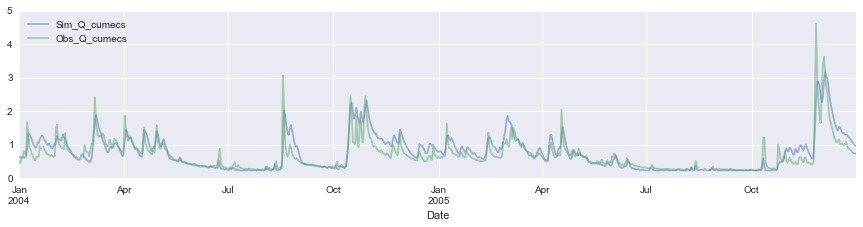

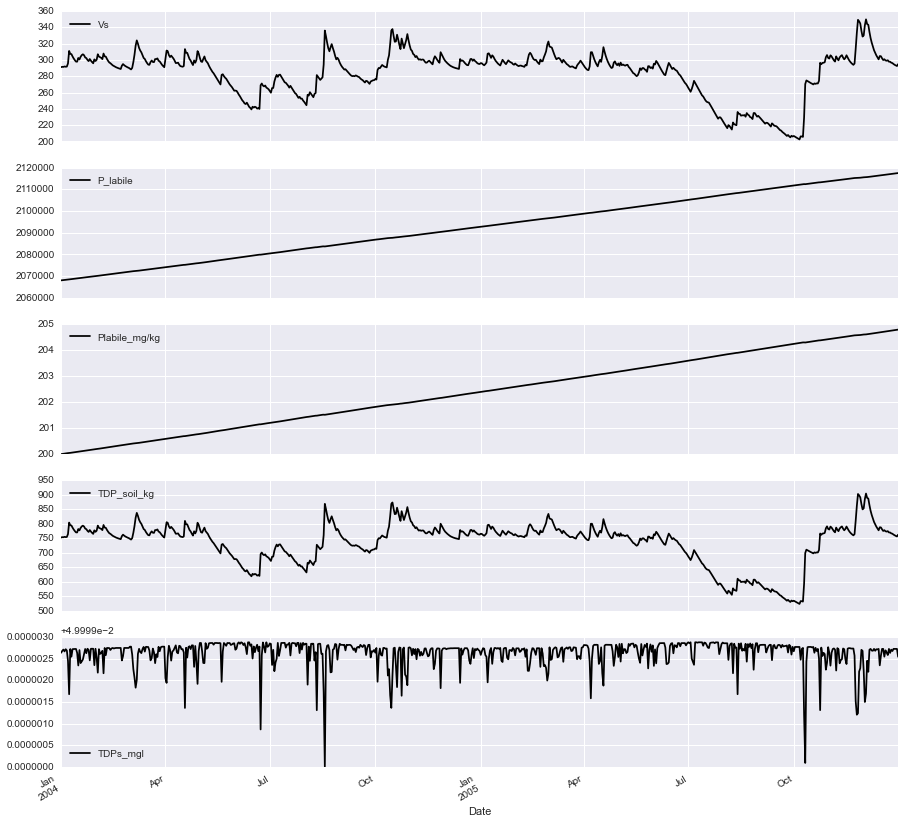

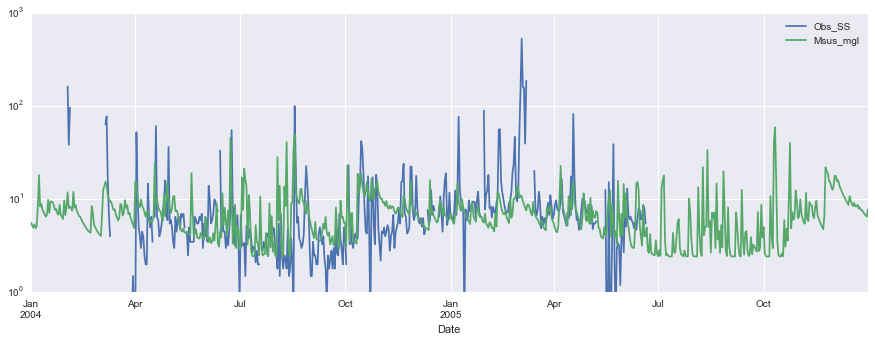

In [41]:
# EXAMINE OUTPUT

# Plot some timeseries

# Hydrology
fig1 = df[['Sim_Q_cumecs', 'Obs_Q_cumecs']].plot(alpha=0.5,figsize=(15, 3))
# df_logs = np.log(df)
# fig2 = df_logs[['Sim_Q_cumecs', 'Obs_Q_cumecs']].plot(alpha=0.5,figsize=(15, 3))

# Internal stuff
# fig3 = df[['Vs','Qs','Vr','Qr','Dr','Mland', 'Msus', 'Msus_mg-l']].plot(subplots=True,figsize=(15, 10))
fig3 = df[['Vs','P_labile','Plabile_mg/kg', 'TDP_soil_kg','TDPs_mgl']].plot(subplots=True,figsize=(15, 15))
# fig3 = df[['Qq','Dr','Vr','Mland', 'Msus', 'Msus_mg-l']].plot(subplots=True,figsize=(15, 15))

# Observed & simulated SS conc
fig4 = df[['Obs_SS', 'Msus_mgl']].plot(figsize=(15,5),logy=True)
fig4.set_ylim(1)
plt.savefig(r'M:\Working\NewModel\ModelOutputs\sed1.png')

# Print some stats
key_dict = {('Q','obs'):'Obs_Q_cumecs', ('Q','sim'):'Sim_Q_cumecs', ('SS','obs'):'Obs_SS', ('SS','sim'):'Msus_mgl'}
for var in ['Q','SS']:
    obs = df[key_dict[(var,'obs')]]
    sim = df[key_dict[(var,'sim')]]
    temp_df = pd.concat([obs,sim],axis=1)
    log_obs = np.log(obs)
    log_sim = np.log(sim)

    NSE = 1 - (np.sum((obs-sim)**2)/np.sum((obs-np.mean(obs))**2))
    log_NSE = 1 - (np.sum((log_obs-log_sim)**2)/np.sum((log_obs-np.mean(log_obs))**2))
    spearmans_r = temp_df.corr(method='spearman')
    r2 = (temp_df.corr(method='pearson'))**2
    print "%s NSE:" %var, NSE
    print "%s NSE on logs" %var, log_NSE
    print "%s Spearman's rank CC:" %var, spearmans_r[key_dict[(var,'obs')]].ix[1]
    print "%s R2:" %var, r2[key_dict[(var,'obs')]].ix[1]

In [42]:
df.sort_index(axis=1)
df.head()

,Vs,Qs,Vg,Qg,Vr,Qr,Dr,Msus,P_labile,TDP_soil_kg,...,Obs_SRP,Obs_SS,Obs_TDP,Obs_TP,Obs_PP,Sim_Q_cumecs,Sim_Vr_l,Msus_mgl,TDPs_mgl,Plabile_mg/kg
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,291.250609,0.027162,59.014131,0.983569,0.233399,1.016636,1.083698,68.270908,2068067.481838,752.907402,...,NaN,NaN,NaN,NaN,NaN,0.648463,12066728.472456,5.657781,0.050002,200.006526
2004-01-02,291.652016,0.176891,58.139568,0.968993,0.237469,1.052405,1.051668,64.618671,2068136.797072,753.945733,...,NaN,NaN,NaN,NaN,NaN,0.629297,12277170.637206,5.263319,0.050002,200.013230
2004-01-03,291.521491,0.226187,57.314629,0.955244,0.237421,1.051975,1.058094,61.014783,2068207.353357,753.608765,...,NaN,NaN,NaN,NaN,NaN,0.633142,12274663.577160,4.970791,0.050002,200.020054
2004-01-04,292.071065,0.228077,56.497215,0.941620,0.236997,1.048217,1.050843,65.948542,2068276.152883,755.028820,...,NaN,NaN,NaN,NaN,NaN,0.628803,12252719.432692,5.382360,0.050002,200.026707
2004-01-05,291.730751,0.294370,55.742189,0.929036,0.237328,1.051152,1.057586,60.097155,2068347.070768,754.149853,...,NaN,NaN,NaN,NaN,NaN,0.632838,12269861.365687,4.897949,0.050002,200.033566


In [43]:
df.tail()

,Vs,Qs,Vg,Qg,Vr,Qr,Dr,Msus,P_labile,TDP_soil_kg,...,Obs_SRP,Obs_SS,Obs_TDP,Obs_TP,Obs_PP,Sim_Q_cumecs,Sim_Vr_l,Msus_mgl,TDPs_mgl,Plabile_mg/kg
Date,,,,,,,,,,,,,,,,,,,,,
2005-12-27,295.068253,1.035627,87.576789,1.459613,0.316989,1.875240,1.886756,118.372247,2117181.255977,762.777693,...,NaN,NaN,NaN,NaN,NaN,1.128996,16388349.522620,7.222951,0.050002,204.756408
2005-12-28,294.088597,0.831749,86.626741,1.443779,0.308679,1.778199,1.794413,111.129598,2117252.449120,760.245195,...,NaN,NaN,NaN,NaN,NaN,1.073740,15958681.463767,6.963583,0.050002,204.763293
2005-12-29,293.280261,0.658228,85.590456,1.426508,0.301091,1.691852,1.708614,104.746354,2117323.642243,758.155574,...,NaN,NaN,NaN,NaN,NaN,1.022400,15566391.513414,6.729007,0.050002,204.770178
2005-12-30,292.617063,0.511438,84.484939,1.408082,0.294170,1.614972,1.632046,99.112719,2117394.835351,756.441149,...,NaN,NaN,NaN,NaN,NaN,0.976583,15208601.727103,6.516886,0.050002,204.777063
2005-12-31,294.900426,0.440653,83.343088,1.389051,0.293709,1.609909,1.613555,119.590559,2117458.539138,762.341082,...,NaN,NaN,NaN,NaN,NaN,0.965518,15184742.568640,7.875705,0.050002,204.783224
